<a href="https://colab.research.google.com/github/os-angel/eda/blob/main/Credit_Card_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Description**


The dataset contains credit card transactions made in September 2013 by some cardholders. In total, the dataset contains 293 fraudulent transactions out of 284,807.

The data contains numerical values due to a transformation from a principal component analysis (PCA). Further personal information about the credit card owners is not available, thus ensuring data confidentiality.

We are going to apply an unsupervised ML algorithm (**K-Means**) to be able to group and predict fraudulent transactions based on input features.


## **Data Download**


The data is available on Kaggle for replication.

[CreditCardFraudDetection](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud)

## **Import Libraries**

First, let's import the necessary libraries for the notebook.

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.gridspec as gridspec
from collections import Counter
from sklearn import metrics
import numpy as np
import warnings
warnings.filterwarnings('ignore', category=UserWarning, message='.*X does not have valid feature names.*')

## **Principal Functions**

**plot_data:**

Visualizes data points on a 2D scatter plot.
Distinguishes two classes using black dots (class 0) and red dots (class 1).
Uses X for data features and y for class labels.
Creates a basic scatter plot for visualizing data distribution.


**plot_centroids:**

Plots cluster centroids as circles with overlaid crosses.
Can filter centroids based on optional weights.
Customizes circle and cross appearance with color and size options.
Highlights the central points representing clusters of data.


**plot_decision_boundaries:**

Visualizes decision boundaries of a clustering algorithm.
Uses clusterer to predict cluster assignments for grid points.
Creates filled contours and contour lines to show cluster regions and boundaries.
Plots data points and optionally centroids on top of the visualization.


**purity score:**

This function is designed to evaluate the performance of a clustering algorithm. It calculates a metric called "purity," which essentially measures how well the clusters produced by the algorithm align with the true labels of the data points.

In [7]:
def plot_data(X, y):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], 'k.', markersize=2)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], 'r.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, y, resolution=1000, show_centroids=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X, y)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

In [8]:
def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

## **Read data**

Read the CSV file into a pandas DataFrame

In [13]:
df = pd.read_csv('creditcard.csv')
df.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## **Exploratory Data Analysis (EDA)**

In [14]:
print("Number of features:", len(df.columns))
print("Lenght of the dataset:", len(df))

Number of features: 31
Lenght of the dataset: 284807


In [15]:
# 492 fraudulent transactions, 284,315 legitimate transactions.
# The dataset is imbalanced.
df["Class"].value_counts()

,count
Class,
0,284315
1,492


In [16]:
# display the types for each attribute
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [19]:
# Check if any column has null values
df.isna().any()

### There is no missing values

,0
Time,False
V1,False
V2,False
V3,False
V4,False
V5,False
V6,False
V7,False
V8,False
V9,False


In [18]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Graphically, we can see for each feature whether there is a difference between the positive and negative examples.

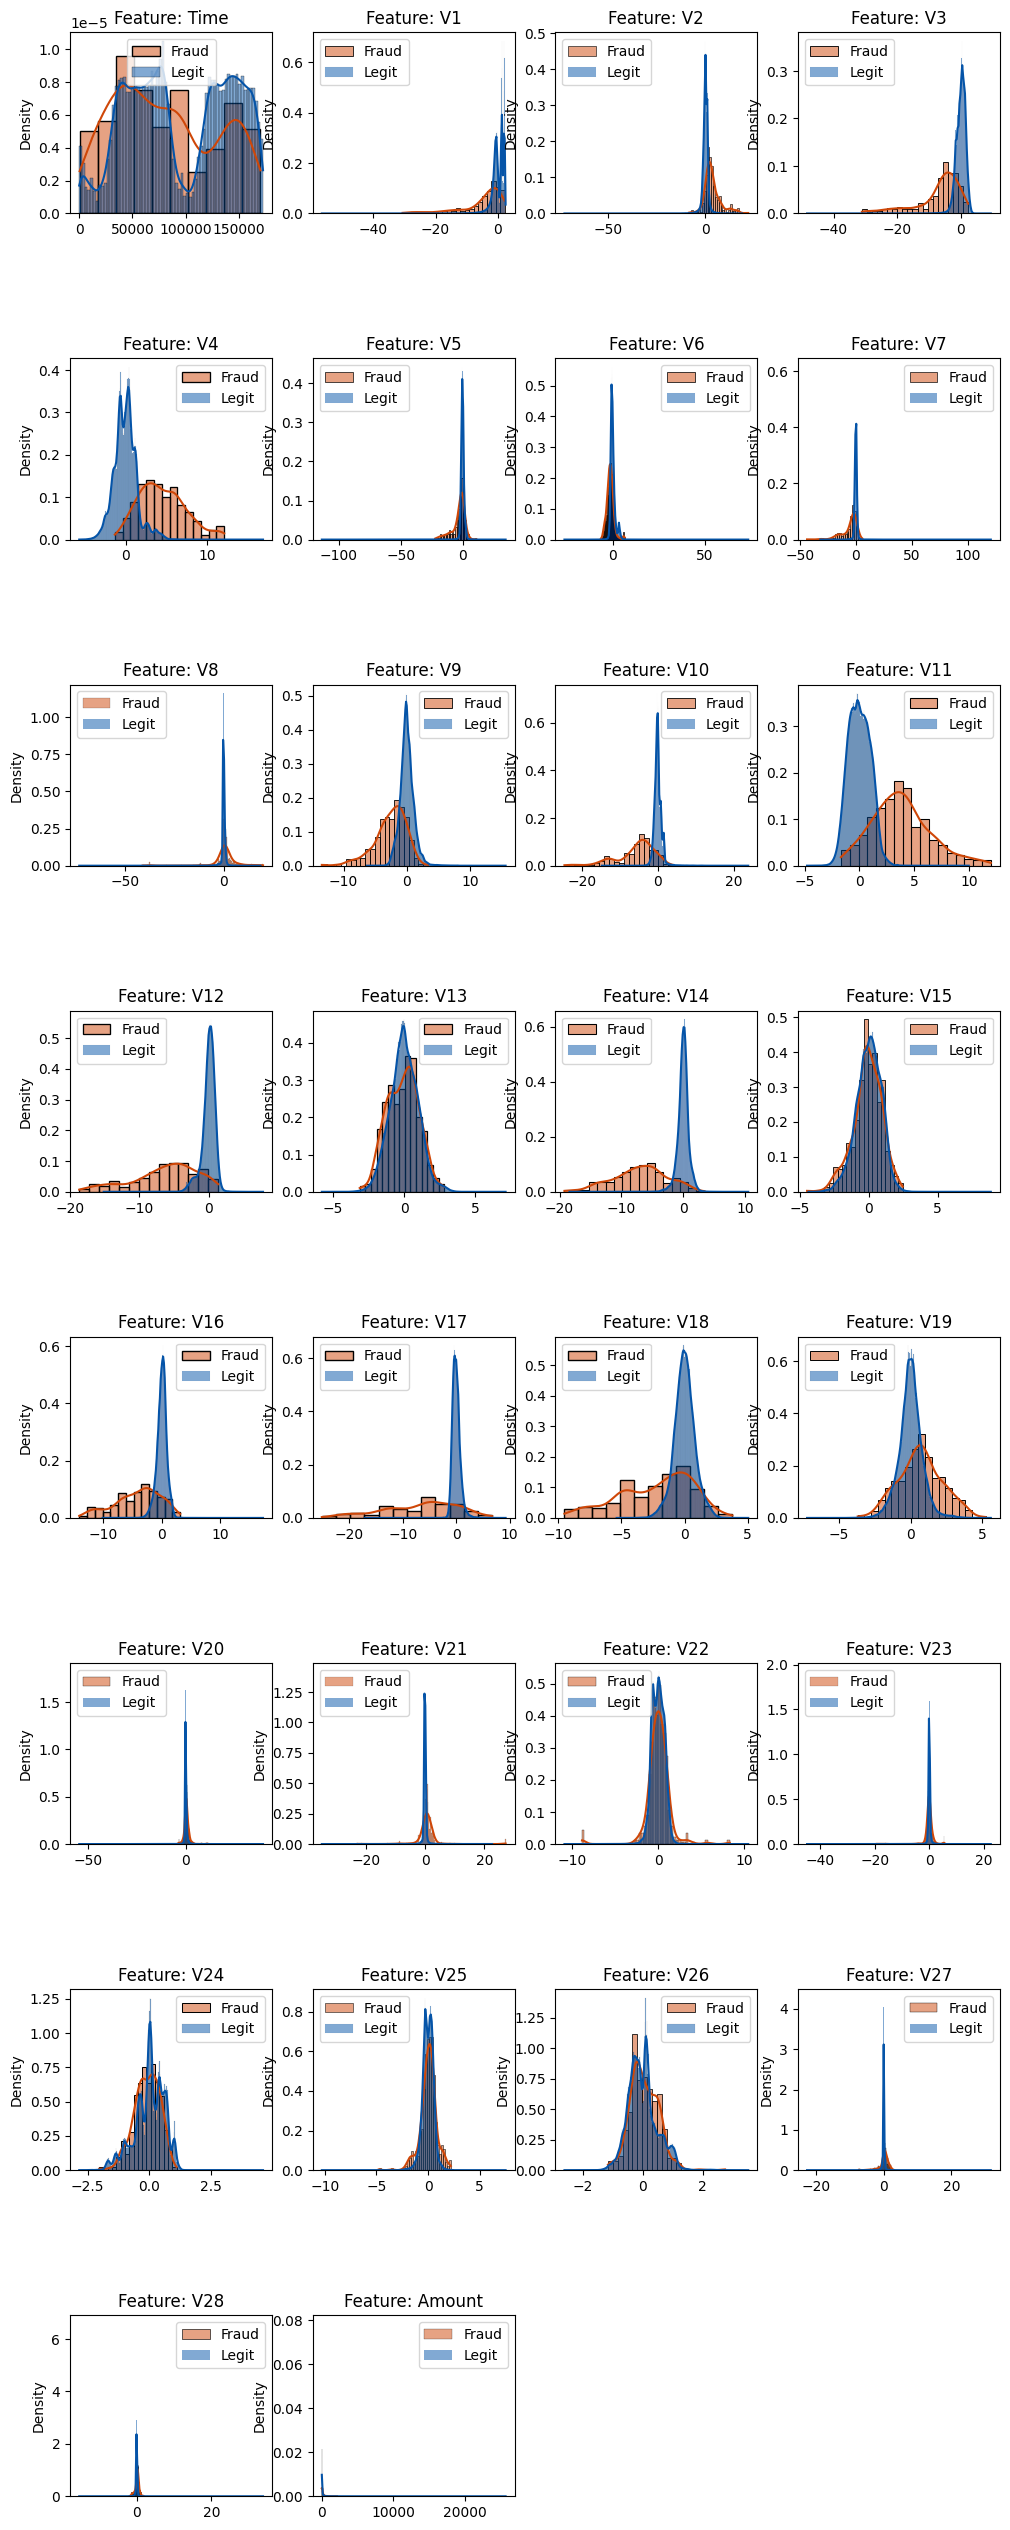

In [24]:
# Representamos gráficamente las características
features = df.drop("Class", axis=1)

plt.figure(figsize=(12, 32))
gs = gridspec.GridSpec(8, 4)
gs.update(hspace=0.8)

for i, f in enumerate(features):
    ax = plt.subplot(gs[i])
    # Usando histplot para los casos donde Class == 1
    sns.histplot(data=df[df["Class"] == 1], x=f, kde=True, color="#cf4708", stat="density", label="Fraud", alpha=0.5)
    # Usando histplot para los casos donde Class == 0
    sns.histplot(data=df[df["Class"] == 0], x=f, kde=True, color="#0554a8", stat="density", label="Legit", alpha=0.5)
    ax.set_xlabel('')
    ax.set_title(f"Feature: {f}")
    ax.legend()

plt.show()

It can be identified in 2D plots that there is a difference between the anomalous (red) and original (green) transactions, using only 2 dimensions of the principal components.

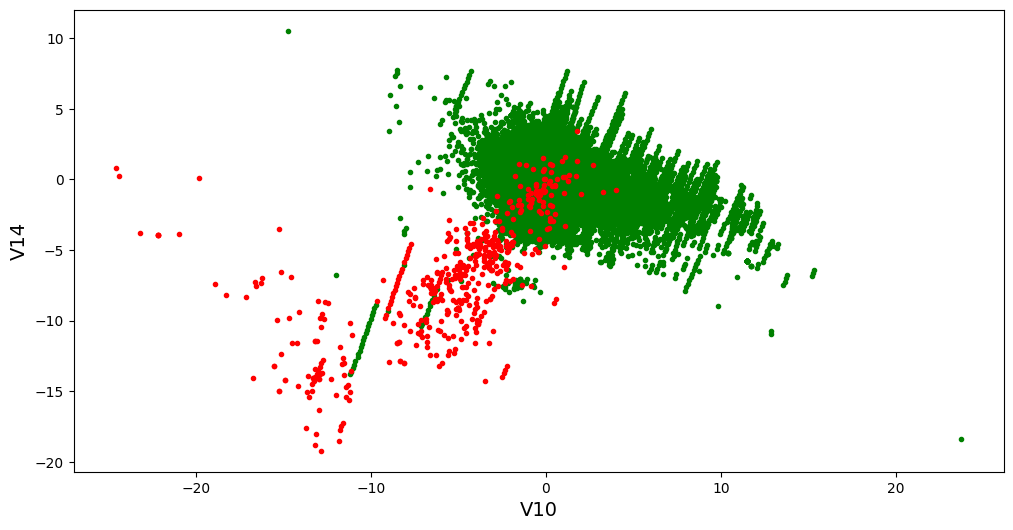

In [22]:
# Representación gráfica de dos características
plt.figure(figsize=(12, 6))
plt.scatter(df["V10"][df['Class'] == 0], df["V14"][df['Class'] == 0], c="g", marker=".")
plt.scatter(df["V10"][df['Class'] == 1], df["V14"][df['Class'] == 1], c="r", marker=".")
plt.xlabel("V10", fontsize=14)
plt.ylabel("V14", fontsize=14)
plt.show()

## **Data Preparation**

For this type of algorithm, it is important that all the data be within a similar range. Therefore, we can apply a scaling or normalization function. Another option is to eliminate features that are not within a similar range, provided they are not very influential for prediction.

In [25]:
df = df.drop(["Time", "Amount"], axis=1)

## **Kmeans with a two-dimensional dataset**

Before starting the KMEANS training with all the attributes of the dataset, a test is performed for two attributes with the objective of understanding how it builds the decision boundary.

In [26]:
X = df[["V10", "V14"]].copy()
X

,V10,V14
0,0.090794,-0.311169
1,-0.166974,-0.143772
2,0.207643,-0.165946
3,-0.054952,-0.287924
4,0.753074,-1.119670
...,...,...
284802,4.356170,4.626942
284803,-0.975926,-0.675143
284804,-0.484782,-0.510602
284805,-0.399126,0.449624


In [27]:
# We generate the clusters for our unlabeled dataset
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X)

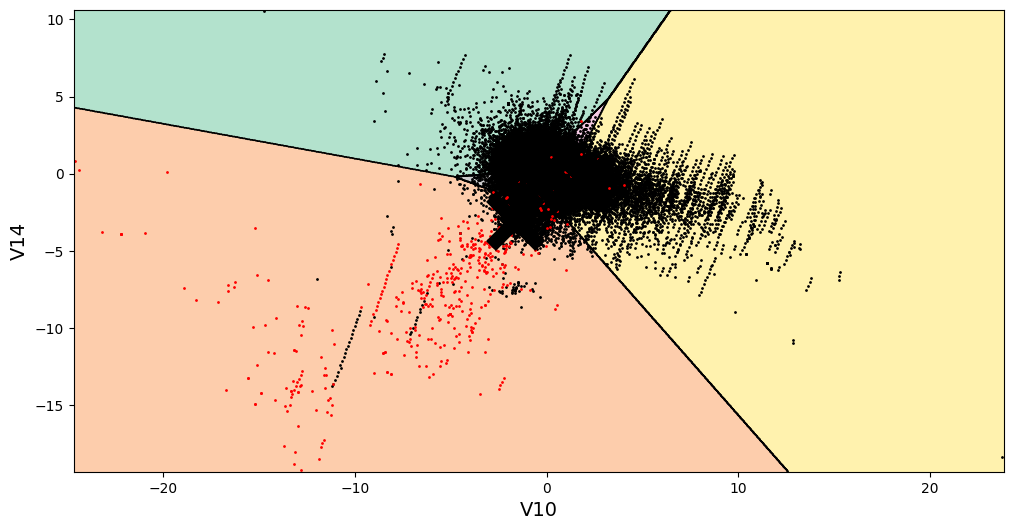

In [28]:
plt.figure(figsize=(12, 6))
plot_decision_boundaries(kmeans, X.values, df["Class"].values)
plt.xlabel("V10", fontsize=14)
plt.ylabel("V14", fontsize=14)
plt.show()

In [29]:
counter = Counter(clusters.tolist())
bad_counter = Counter(clusters[df['Class'] == 1].tolist())

for key in sorted(counter.keys()):
    print("Label {0} has {1} samples - {2} are malicious samples".format(
        key, counter[key], bad_counter[key]))

Label 0 has 48659 samples - 6 are malicious samples
Label 1 has 5631 samples - 429 are malicious samples
Label 2 has 121724 samples - 18 are malicious samples
Label 3 has 27404 samples - 8 are malicious samples
Label 4 has 81389 samples - 31 are malicious samples


## **Kmeans with a multidimensional dataset**

Being an algorithm based on unsupervised learning, labels are not required for training or prediction. It should be noted that in this type of problem, it is assumed that labels are not available.

In [30]:
from sklearn.cluster import KMeans
X = df.drop("Class", axis=1)
y = df["Class"].copy()
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X)

In [32]:
# We evaluate the clusters and the content that has been formed
counter = Counter(clusters.tolist())
bad_counter = Counter(clusters[y == 1].tolist())

for key in sorted(counter.keys()):
    print("Label {0} has {1} samples - {2} are malicious samples".format(
        key, counter[key], bad_counter[key]))

Label 0 has 44522 samples - 228 are malicious samples
Label 1 has 100946 samples - 81 are malicious samples
Label 2 has 17163 samples - 0 are malicious samples
Label 3 has 3630 samples - 129 are malicious samples
Label 4 has 118546 samples - 54 are malicious samples


## **Feature Reduction**


On many occasions, Kmeans performs better with a lower number of features.

Applying feature selection with Random Forest


In [33]:
# We use Random Forest to perform feature selection

from sklearn.ensemble import RandomForestClassifier

clf_rnd = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
clf_rnd.fit(X, y)

RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42)

In [34]:
# select really important features
feature_importances = {name: score for name, score in zip(list(df), clf_rnd.feature_importances_)}
feature_importances_sorted = pd.Series(feature_importances).sort_values(ascending=False)

In [35]:
# Reduce the dataset to the 7 most important features
X_reduced = X[list(feature_importances_sorted.head(7).index)].copy()
X_reduced

,V17,V14,V16,V12,V10,V11,V18
0,0.207971,-0.311169,-0.470401,-0.617801,0.090794,-0.551600,0.025791
1,-0.114805,-0.143772,0.463917,1.065235,-0.166974,1.612727,-0.183361
2,1.109969,-0.165946,-2.890083,0.066084,0.207643,0.624501,-0.121359
3,-0.684093,-0.287924,-1.059647,0.178228,-0.054952,-0.226487,1.965775
4,-0.237033,-1.119670,-0.451449,0.538196,0.753074,-0.822843,-0.038195
...,...,...,...,...,...,...,...
284802,1.991691,4.626942,1.107641,2.711941,4.356170,-1.593105,0.510632
284803,-0.025693,-0.675143,-0.711757,0.915802,-0.975926,-0.150189,-1.221179
284804,0.313502,-0.510602,0.140716,0.063119,-0.484782,0.411614,0.395652
284805,0.509928,0.449624,-0.608577,-0.962886,-0.399126,-1.933849,1.113981


## **K-Means with reduced dataset**

In [36]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X_reduced)
# Evaluamos los clusters y el contenido que se han formado
counter = Counter(clusters.tolist())
bad_counter = Counter(clusters[y == 1].tolist())

for key in sorted(counter.keys()):
    print("Label {0} has {1} samples - {2} are malicious samples".format(
        key, counter[key], bad_counter[key]))


Label 0 has 109253 samples - 19 are malicious samples
Label 1 has 124538 samples - 17 are malicious samples
Label 2 has 30408 samples - 161 are malicious samples
Label 3 has 308 samples - 265 are malicious samples
Label 4 has 20300 samples - 30 are malicious samples


## **Evaluation of the Results**

Caution should be exercised with imbalanced datasets when using metrics to measure cluster purity. A possible solution is to utilize dataset balancing techniques, such as generating more examples of fraudulent transactions or decreasing examples of legitimate transactions.


**Purity Score (0.999):** A high purity score close to 1 indicates that the clusters contain predominantly data points from a single class, which is desirable in this case where we aim to identify fraudulent transactions. This implies good performance in grouping similar transactions together.

**Silhouette Score (0.179):** A Silhouette score closer to 1 indicates well-separated and distinct clusters. The relatively low value here suggests that the clusters might be overlapping or not clearly defined. This could indicate some ambiguity in the clustering, potentially leading to misclassification of some transactions.

**Calinski-Harabasz Score (38466):** A higher Calinski-Harabasz score indicates better-defined clusters with high intra-cluster density and inter-cluster separation. The significantly high value here supports a good overall clustering structure despite the lower Silhouette score. This suggests that the clusters are generally compact and well-separated, despite some potential overlap.



In [37]:
print("Purity Score:", purity_score(y, clusters))
print("Shiloutte: ", metrics.silhouette_score(X_reduced, clusters, sample_size=10000))
print("Calinski harabasz: ", metrics.calinski_harabasz_score(X_reduced, clusters))

Purity Score: 0.9990519895929524
Shiloutte:  0.17978267931744193
Calinski harabasz:  38466.001407022675



## **Conclusion**

The clustering results indicate a high purity score (0.999), suggesting that the clusters are relatively homogeneous and contain mostly data points from the same class. However, the relatively low Silhouette score (0.179) indicates that the clusters might be overlapping or not well-separated. Despite this, the Calinski-Harabasz score (38466) is high, suggesting a good overall clustering structure with dense and well-separated clusters.

